In [28]:
import numpy as np # import libraries
import matplotlib.pyplot as plt
import re
import zipfile
import getpass
import os  # for chdir, getcwd, path.basename, path.exists
from os.path import join
import pandas as pd # for DatetimeIndex
import codecs # for text parsing code
import netrc
import rasterio as rio
import glob
from osgeo import gdal
import io
import shutil
from subprocess import PIPE, Popen
import subprocess
import fcntl ##may need to pip install this one
import select
import sys
import hvplot.xarray
import rioxarray

#local imports
from snowexsql.snowexsql.conversions import INSAR_to_rasterio
from snowexsql.snowexsql.metadata import read_InSar_annotation
from snowexsql.snowexsql.projection import reproject_raster_by_epsg

In [29]:
home_dir = '/SNOWDATA/uavsar/' #this needs to be a file path to the directory you want to save folders
url_dir = join(home_dir,'imgs' ,'urls','') #this should be a relative or full file path to where your urls are stored in txt or csv files
data_dir = join(home_dir,'imgs') #function might call this the out_dir
os.makedirs(data_dir, exist_ok=True)

In [30]:
locs = [ loc for loc in os.listdir(data_dir) if 'urls' not in loc]
for loc in locs:
    loc_dir = join(data_dir, loc)
    imgs = [img for img in os.listdir(loc_dir) if 'tmp' not in img]
    for img in imgs:
        img_dir = join(loc_dir, img)
        fps = [join(img_dir, fp) for fp in os.listdir(img_dir) if '.tif' in fp]

In [31]:
locs = [ loc for loc in os.listdir(data_dir) if 'urls' not in loc]
for loc in locs:
    loc_dir = join(data_dir, loc)
    imgs = [img for img in os.listdir(loc_dir) if 'tmp' not in img]
    for img in imgs:
        img_dir = join(loc_dir, img)
        csvs = [join(img_dir, fp) for fp in os.listdir(img_dir) if '.csv' in fp]

In [32]:
desc = pd.read_csv(csvs[0])

In [33]:
for col in desc.columns:
    print(col)
    print(desc[col])

Unnamed: 0
0      value
1      units
2    comment
Name: Unnamed: 0, dtype: object
uavsar rpi annotation file version number
0                                                  2.3
1                                                    -
2    uavsar rpi annotation file version number     ...
Name: uavsar rpi annotation file version number, dtype: object
site description
0                                           Lowman, CO
1                                                    &
2    site description                              ...
Name: site description, dtype: object
flight plan comments of pass 1
0                                                  NaN
1                                                    &
2    flight plan comments of pass 1                ...
Name: flight plan comments of pass 1, dtype: object
flight plan comments of pass 2
0                                                  NaN
1                                                    &
2    flight plan comments of pass 2    

In [34]:
path = fps[0]
print(os.path.basename(path))

lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.amp1.real.tif


In [35]:
lat = desc['grd.row_addr'][0]
long = desc['grd.col_addr'][0]
print(f'left upper is {lat} , {long}')

left upper is 44.512171800000004 , -116.32236060000001


In [36]:
da = rioxarray.open_rasterio(path, masked=True)

In [37]:
# the rioxarray 'rio' accessor gives us access to geospatial information and other methods
crs = da.rio.crs
print(da.rio.encoded_nodata)
print('Upper left corner:')
print(da.rio.transform() * (0, 0)) 
print('Bounds of img: ')
print(da.rio.bounds())
left, bottom, right, top = da.rio.bounds()

None
Upper left corner:
(553859.6221955194, 4931021.2988628335)
Bounds of img: 
(553859.6221955194, 4822498.443121072, 674122.4174766277, 4931021.2988628335)


In [12]:
# import pyproj
# in_proj = pyproj.Proj(init="epsg:{}".format(crs.to_epsg()))
# out_proj = pyproj.Proj(init="epsg:4326")

# lons, lats = pyproj.transform(in_proj, out_proj, [left, left + 5], [top, top])


In [ ]:
da.hvplot.image(x='x', y='y',rasterize=False, cmap='gray', tiles = True)

In [38]:
# Drop the 'band' dimension since we don't have multiband data
da = da.squeeze('band', drop=True)
da.name = 'nasadem'
da

<xarray.DataArray 'nasadem' (y: 21603, x: 23940)>
[517175820 values with dtype=float32]
Coordinates:
  * x            (x) float64 5.539e+05 5.539e+05 ... 6.741e+05 6.741e+05
  * y            (y) float64 4.931e+06 4.931e+06 ... 4.823e+06 4.823e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

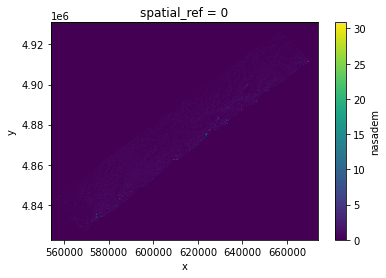

In [39]:
da.plot()

In [40]:
da.hvplot.image(rasterize = True) #rasterize = False

:DynamicMap   []
   :Image   [y,x]   (nasadem)

In [ ]:
da_reproject = da.rio.reproject("EPSG:4326")

In [27]:
da_reproject.rio.encoded_nodata = np.nan

AttributeError: can't set attribute

In [22]:
da_reproject.hvplot.image(rasterize = True, geo=True, tiles='ESRI') #rasterize = False

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (nasadem)